# Cellular properties overview & Single-cell/global correlations

## imports & installations

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import sys
import scipy
import itertools
import os
import scipy

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append('/sise/home/shakarch/muscle-formation-regeneration')
sys.path.append(os.path.abspath('..'))

from TimeSeriesAnalysis.utils.data_load_save import *
import TimeSeriesAnalysis.params as params
from TimeSeriesAnalysis.auc_over_time_diff_prob import *

## data loading - differentiation scores dataframes & other calculated properties

In [2]:
# properties_df_s5 =  get_all_properties_df("actin_intensity", 2, 3, scores_vid_num=5)
# properties_df_s1 =  get_all_properties_df("actin_intensity", 2, 3, scores_vid_num=1)
properties_df_s3 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=3)
properties_df_s2 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=2)
# properties_df_s6 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=6)
# properties_df_s8 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=8)

properties_df_s3.head()


,score_motility,score_intensity,coordination,local_density,Spot frame,time,Spot track ID,min,max,mean,sum,x,y,persistence,directionality_cos_alpha,speed,speed_change,Spot position X,Spot position Y
0,0.934742,0.23622,NaN,6.0,82.0,6.833333,1.0,188.0,711.0,379.057617,388155.0,2041.0,2504.0,0.072409,0.641977,2.890145,-0.533617,943.222656,1156.871826
1,0.899424,0.245184,NaN,6.0,83.0,6.916667,1.0,230.0,763.0,392.603516,402026.0,2041.0,2493.0,0.060796,-0.006073,4.653162,1.763017,943.194397,1152.218750
2,0.896553,0.196739,NaN,6.0,84.0,7.000000,1.0,186.0,1121.0,371.957031,380884.0,2041.0,2484.0,0.050120,-0.023499,4.394768,-0.258394,943.091125,1147.825195
3,0.905297,0.316343,NaN,6.0,85.0,7.083333,1.0,106.0,1583.0,375.641602,384657.0,2042.0,2472.0,0.020904,0.059311,5.429358,1.034590,943.413147,1142.405396
4,0.86811,0.274264,NaN,6.0,86.0,7.166667,1.0,182.0,4881.0,586.167969,600236.0,2040.0,2462.0,0.058198,-0.178587,4.794980,-0.634378,942.556824,1137.687500


In [3]:
# re-add spot position columns and recalculate speed

def add_spot_position_columns(properties_df, vid_num):
    prop_cols = ["Spot track ID","Spot frame", "score_motility", "score_intensity","coordination", "local_density", 
                                                  "time", "min", "max", "mean", "sum", "persistence", "directionality_cos_alpha"]
    df_s_cols = ["Spot track ID","Spot frame","Spot position X", "Spot position Y"]
    
    path = fr'/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/data/mastodon/{params.registration_method}'
    s_df, s_track_list = get_tracks(path + f"S{vid_num} all detections.csv", manual_tagged_list=True)
    
    properties_df = pd.merge(left=properties_df[prop_cols], 
                                right=s_df.drop_duplicates(subset=["Spot track ID","Spot frame"])[df_s_cols] ,
                                on=["Spot track ID","Spot frame"], how='left')
    return properties_df
    
# properties_df_s6 = add_spot_position_columns(properties_df_s6, 6)
# properties_df_s8 = add_spot_position_columns(properties_df_s8, 8)

properties_df_s3 = add_spot_position_columns(properties_df_s3, 3)
properties_df_s2 = add_spot_position_columns(properties_df_s2, 2)

# properties_df_s1 = add_spot_position_columns(properties_df_s1, 1)
# properties_df_s5 = add_spot_position_columns(properties_df_s5, 5)


def get_new_speed(track_data):
    pd.options.display.float_format = '{:,.4f}'.format 
    x_col = "Spot position X"
    y_col = "Spot position Y"
    track_data["time"] = track_data["Spot frame"] * 5 / 60
    track_data = track_data[["Spot frame", x_col, y_col, "Spot track ID", "time"]]
    track_data = track_data.sort_values("Spot frame")

    track_data['speed_x'] = track_data.groupby(['Spot track ID'])[x_col].transform(lambda x: x.diff()) 
    track_data['speed_y'] = track_data.groupby(['Spot track ID'])[y_col].transform(lambda x: x.diff()) 

    track_data["speed"] = np.sqrt(np.square(track_data["speed_x"]) + np.square(track_data["speed_y"]))
    track_data['speed_change'] = track_data.groupby(['Spot track ID'])['speed'].diff()#.transform(lambda x: x.pct_change()) 
    
    return track_data["speed"], track_data['speed_change']

# properties_df_s6["speed"], properties_df_s6['speed_change'] = get_new_speed(properties_df_s6)
properties_df_s3["speed"], properties_df_s3['speed_change'] = get_new_speed(properties_df_s3)
properties_df_s2["speed"], properties_df_s2['speed_change'] = get_new_speed(properties_df_s2)
# properties_df_s8["speed"], properties_df_s8['speed_change'] = get_new_speed(properties_df_s8)

# properties_df_s5["speed"], properties_df_s5['speed_change'] = get_new_speed(properties_df_s5)
# properties_df_s1["speed"], properties_df_s1['speed_change'] = get_new_speed(properties_df_s1)


motility mean 0.20423404255319147 median 0.388
intensity mean 0.30939007092198584 median 0.554


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


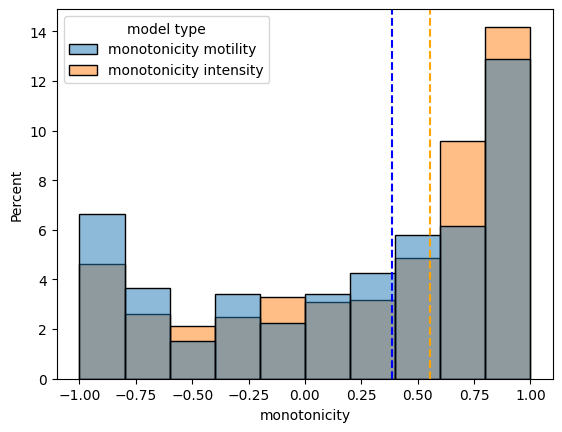

In [4]:
def get_monotonicity(track_df, modality, time, rolling_window=1, corr_metric="spearman"):
    track_df = track_df[(track_df["time"]>=time[0]) & (track_df["time"]<=time[1])]
    corr = np.array(track_df.astype('float32').groupby('Spot track ID').apply(lambda df: df[f"score_{modality}"].rolling(rolling_window).mean().corr(df["time"].rolling(rolling_window).mean(),method=corr_metric)))
    corr = corr[0] if len(corr) > 0 else np.nan 
    return round(corr, 3)

def plot_monotonicity_dist(df, vid_num, time, rolling_window, corr_metric):
    mono_values_mot = []
    mono_values_int = []
    for track_id, track_df in df.groupby("Spot track ID"):
        if len(track_df) > rolling_window:
            mono = get_monotonicity(track_df, "motility", time, rolling_window, corr_metric)
            mono_values_mot.append(mono)
            mono = get_monotonicity(track_df, "intensity", time, rolling_window, corr_metric)
            mono_values_int.append(mono)
    df_mot = pd.DataFrame({"monotonicity": mono_values_mot, "model type": "monotonicity motility"})
    df_int = pd.DataFrame({"monotonicity": mono_values_int, "model type": "monotonicity intensity"})

    print("motility", "mean", df_mot["monotonicity"].mean(), "median", df_mot["monotonicity"].median())
    print("intensity", "mean", df_int["monotonicity"].mean(), "median", df_int["monotonicity"].median())
    df = pd.concat([df_mot, df_int], ignore_index=True, axis=0)
    sns.histplot(df, x="monotonicity", hue="model type", label= "monotonicity" + " motility", stat="percent", bins=10)
    plt.axvline(df_mot["monotonicity"].median(), color='blue', linestyle='dashed')
    plt.axvline(df_int["monotonicity"].median(), color='orange', linestyle='dashed')

    
    plt.savefig(consts.storage_path + f"eps_figs/monotonicity distribution over time vid {vid_num}.eps", format="eps")
    plt.show()
    
plot_monotonicity_dist(properties_df_s3, 3, time=(6,13), rolling_window=6, corr_metric="spearman")
# plot_monotonicity_dist(properties_df_s5, 5, time=(6,13), rolling_window=6, corr_metric="spearman")

motility diff time normality NormaltestResult(statistic=42.06063917661637, pvalue=7.356110597483707e-10)
actin diff time normality NormaltestResult(statistic=18.400783788491605, pvalue=0.00010099981283477183)
motility #cells 234/574
actin #cells 247/574
motility:  mean- 4.108974358974359 median- 3.291666666666667 std- 3.0361724348560912
actin:  mean- 5.124493927125506 median- 4.5 std- 3.117050597750649


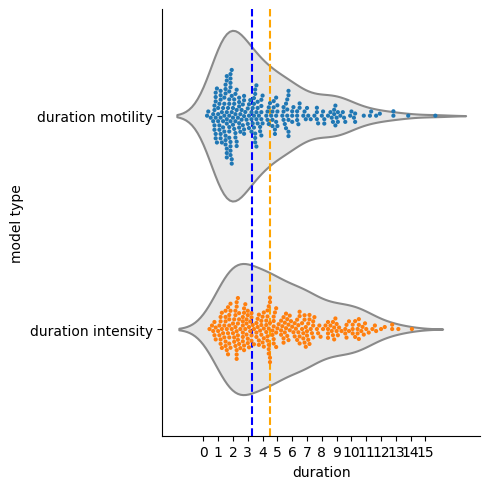

In [22]:
from itertools import groupby
from scipy.stats import normaltest

def get_terminal_differentiation_time(diff_threshold, track_df, modality):
    high_then_thresh = track_df[(track_df[f"score_{modality}"] >= diff_threshold) & (track_df[f"time"] >= 0)]
    high_then_thresh["Spot frame diff"] = high_then_thresh["Spot frame"].diff()
    sequences = [ v for k, v in high_then_thresh.groupby((high_then_thresh["Spot frame diff"].shift() != high_then_thresh["Spot frame diff"]).cumsum())]
    if len(sequences) == 0:
        return np.nan, np.nan
    else: 
        longest_sequence = max(sequences, key=len)
        diff_frame = np.floor(longest_sequence["Spot frame"].min()) # change to adjust
        diff_time = diff_frame * 1 / 12
        return diff_frame, diff_time

def get_stable_threshold_time(threshold, track_df, modality, time_thresh=24):
    thresholded_data = track_df[(track_df[f"score_{modality}"] >= threshold[0]) & (track_df[f"score_{modality}"] <= threshold[1]) & (track_df[f"time"] <= time_thresh)]
    thresholded_data["Spot frame diff"] = thresholded_data["Spot frame"].diff()
    sequences = [ v for k, v in thresholded_data.groupby((thresholded_data["Spot frame diff"].shift() != thresholded_data["Spot frame diff"]).cumsum())]
    if len(sequences) == 0:
        return np.nan, np.nan
    else: 
        longest_sequence = max(sequences, key=len)
        ind  = np.array(longest_sequence[f"score_{modality}"]).argmax() #change to adjust
        threshold_frame = longest_sequence.iloc[ind]["Spot frame"]
                
        threshold_time = threshold_frame * 1 / 12
        return threshold_frame, threshold_time
    
    
def plot_diff_duration_dist(df, vid_num):
    duration_values_mot = []
    duration_values_int = []
    for track_id, track_df in df.groupby("Spot track ID"):
#         _, diff_time = get_terminal_differentiation_time(0.8, track_df, "motility")
        _, diff_time = get_stable_threshold_time((0.7, 0.8), track_df, "motility")
        _, low_thresh_time = get_stable_threshold_time((0.2, 0.3), track_df, "motility", time_thresh=diff_time)
        duration = diff_time - low_thresh_time
        duration_values_mot.append(duration)

#         _, diff_time = get_terminal_differentiation_time(0.8, track_df, "intensity")
        _, diff_time = get_stable_threshold_time((0.7, 0.8), track_df, "intensity")
        _, low_thresh_time = get_stable_threshold_time((0.2, 0.3), track_df, "intensity", time_thresh=diff_time)
        duration = diff_time - low_thresh_time
        duration_values_int.append(duration)
            
    df_mot = pd.DataFrame({"duration": duration_values_mot, "model type": "duration motility"})
    df_int = pd.DataFrame({"duration": duration_values_int, "model type": "duration intensity"})
    
    print("motility diff time normality",normaltest(df_mot["duration"], nan_policy='omit'))
    print("actin diff time normality",normaltest(df_int["duration"], nan_policy='omit'))
    print("motility #cells", f"{len(df_mot.dropna())}/{df['Spot track ID'].nunique()}")
    print("actin #cells", f"{len(df_int.dropna())}/{df['Spot track ID'].nunique()}")

    print("motility: ", "mean-", df_mot["duration"].mean(), "median-",  df_mot["duration"].median(), "std-", df_mot["duration"].std())
    print("actin: ", "mean-",  df_int["duration"].mean(), "median-",  df_int["duration"].median(), "std-", df_int["duration"].std())
    df = pd.concat([df_mot, df_int], ignore_index=True, axis=0)
    
    catplot = sns.catplot(data=df, x="duration", y="model type", kind="violin", color=".9", inner=None, show_mean=True)
    swarmplot = sns.swarmplot(data=df, x="duration", y="model type", size=3) 
    
    plt.axvline(df_mot["duration"].median(), color='blue', linestyle='dashed')
    plt.axvline(df_int["duration"].median(), color='orange', linestyle='dashed')
    
    plt.xticks(range(int(df["duration"].max())+1))
    plt.savefig(consts.storage_path + f"eps_figs/diff duration distribution over time vid {vid_num}.eps", format="eps")
    plt.show()

plot_diff_duration_dist(properties_df_s3, 3)
# plot_diff_duration_dist(properties_df_s5, 5)

## Cellular properties overview

the displayed data: 

S3 video, (Erki, 211212_CD7_ERK_P38), S2 video, (DMSO, 211212_CD7_ERK_P38), S6 video, (Erki + P38, 211212_CD7_ERK_P38), S8 video, (P38, 211212_CD7_ERK_P38)  
as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells.

In [186]:
def plot_property_over_time(properties_df_lst, features_list, time=(0,25)):
    sns.set_style("whitegrid")
    dfs = list(map(lambda x: x[0], properties_df_lst))
    labels = list(map(lambda x: x[1], properties_df_lst))
    colors = list(map(lambda x: x[2], properties_df_lst))

    tot = len(features_list)
    cols = 2
    rows = tot // cols
    # EDIT for correct number of rows:
    # If one additional row is necessary -> add one:
    if tot % cols != 0:
        rows += 1
    position = range(1, tot + 1)
    fig = plt.figure(1, figsize=(14,14))

    for k in range(tot):
        f = features_list[k]
        ax = fig.add_subplot(rows, cols, position[k])
        for df, label, color in zip(dfs, labels, colors):   

            
            df = df[(df["time"]>= time[0]) & (df["time"]< time[1])]
            df = df.sort_values("time")
            mean = round(df.dropna(subset=[f]).groupby("time")[f].mean(), 2).rolling(1).mean()
            std = round(df.dropna(subset=[f]).groupby("time")[f].std(), 2).rolling(1).mean()
#             print(round(std, 3))
            ax.plot(mean, color=color, label=label)
            plt.fill_between(df["time"].unique()[:len(mean)], mean - std, mean + std, alpha=0.4, color=color, label=label)
            
            ax.axvspan(6, 13, alpha=0.3, color='lightgray')
            ax.axvline(6, color='gray', linestyle='dashed')
            ax.axvline(13, color='gray', linestyle='dashed')
            
            ax.set_ylabel(f"{f}")
            ax.set_xlabel(f"time")
            ax.set_title(f'{f} over time')
            ax.grid(False)
#             ax.set_yticks(np.arange(-5, 20, step=2.5))
#             ax.set_ylim((0,12))
            ax.legend()
            
    plt.savefig(consts.storage_path + f"eps_figs/property_over_time {str(labels)}.eps", format="eps")

time = (4,15)  
features_list = ["speed", "local_density", "persistence", "mean"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


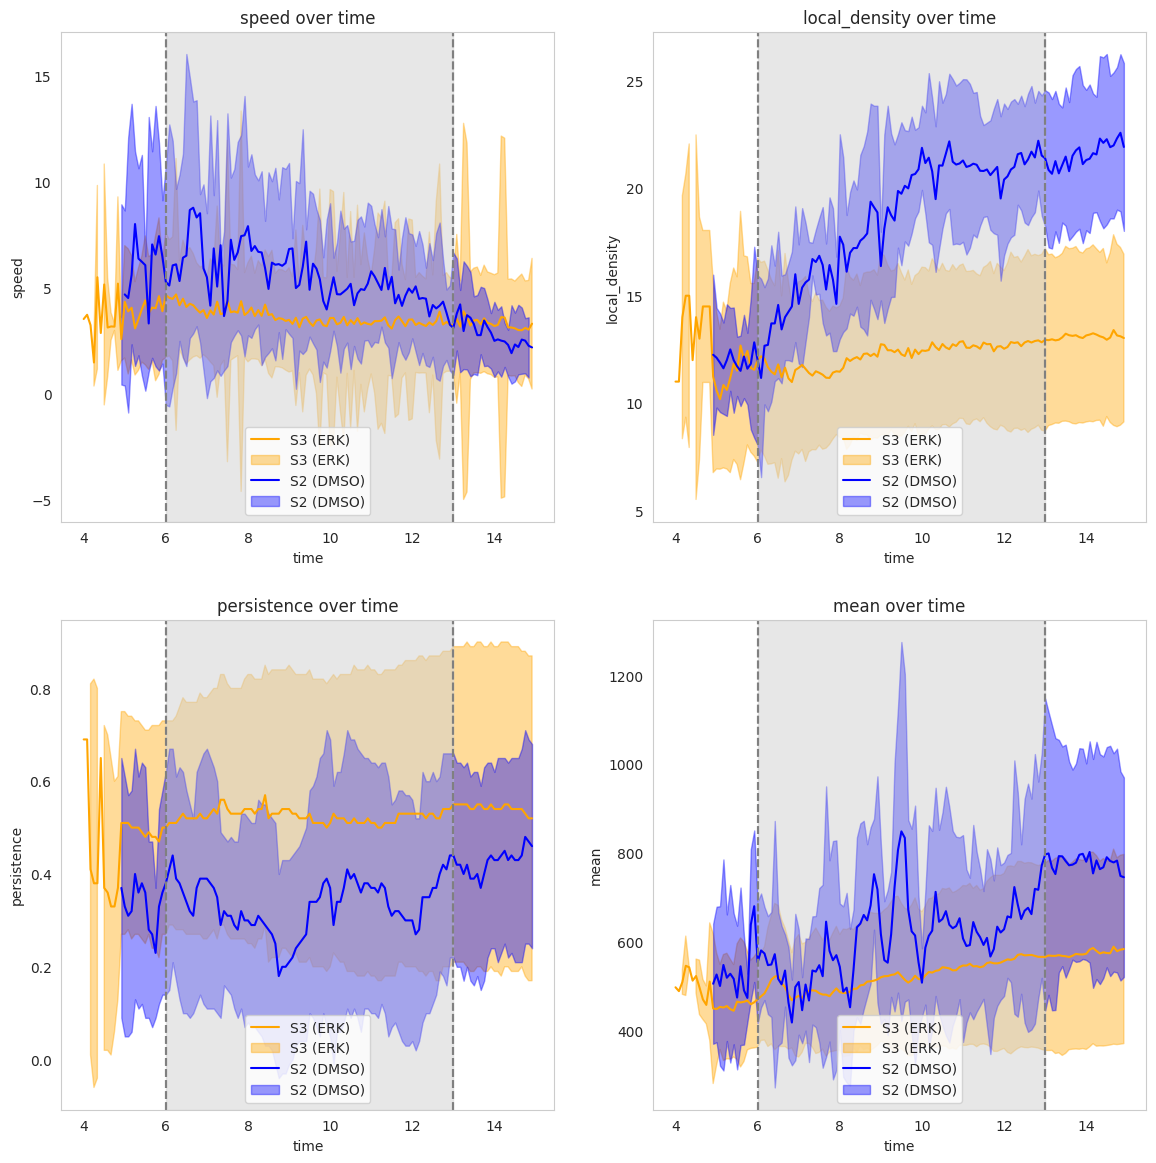

In [187]:
data = [(properties_df_s3, "S3 (ERK)","orange") ,(properties_df_s2, "S2 (DMSO)", "blue")]
plot_property_over_time(data, features_list, time=time)

the displayed data: 

S1 video, (DMSO,211006_CD7_DMSO_ERKi), S5 video, (Erki,211006_CD7_DMSO_ERKi)
as the test set data. the scores are based on a model that was trained on videos S3 (Erki, 211212_CD7_ERK_P38) & S2 (DMSO, 211212_CD7_ERK_P38).
The followiing displayed trackes are *all* the manually-tracked cells.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


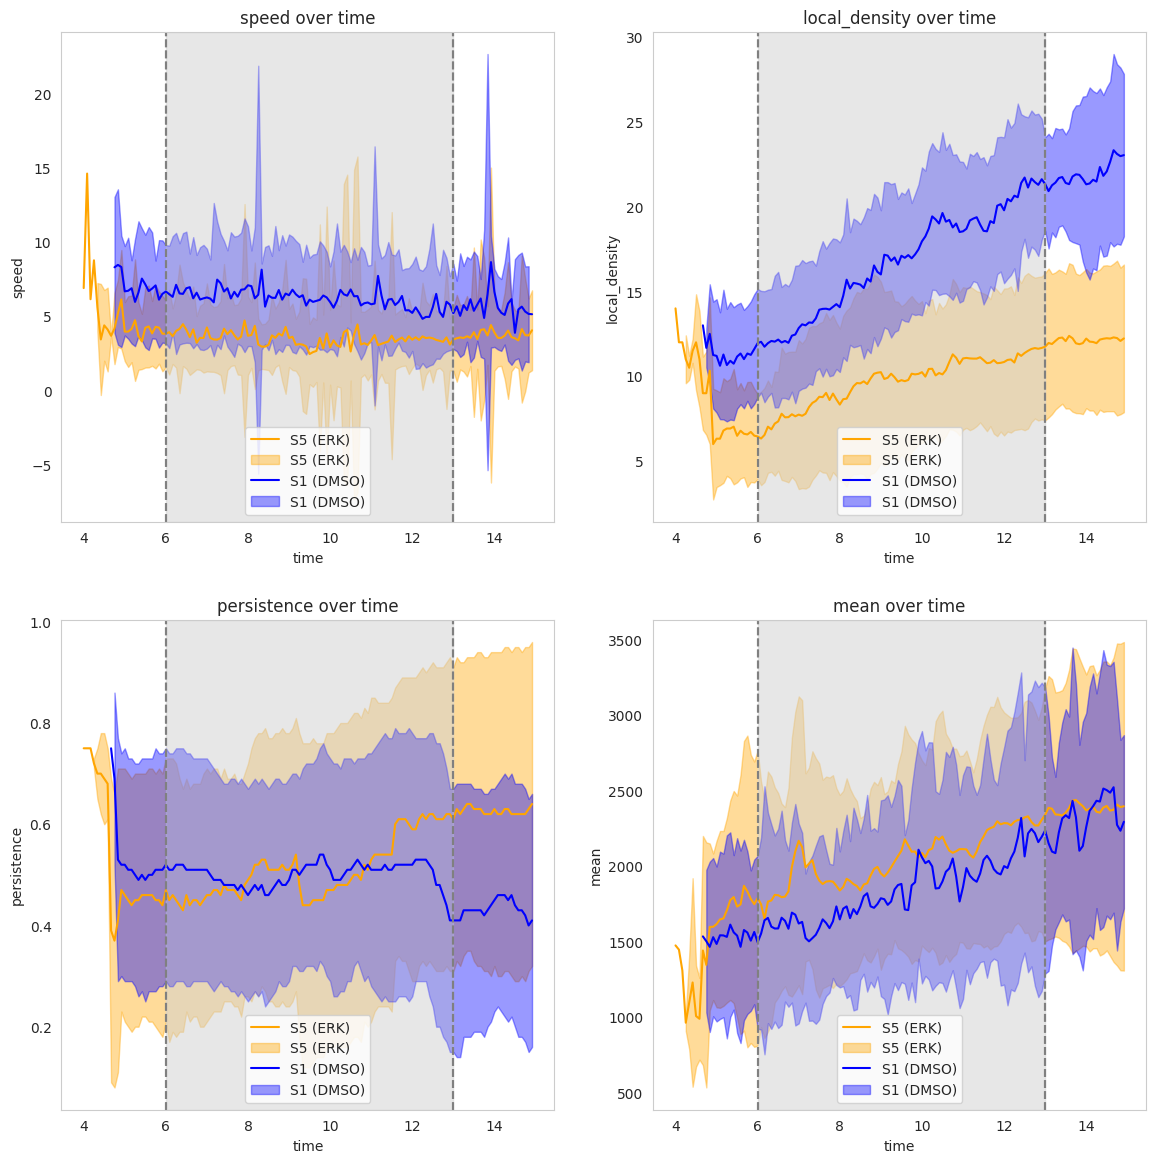

In [188]:
data = [(properties_df_s5, "S5 (ERK)","orange") ,(properties_df_s1, "S1 (DMSO)", "blue")]
plot_property_over_time(data, features_list, time=time)

## Correlations- Single cell Level

### display a single cell level correlations in a distribution

In [7]:
def get_corr_values(data, time, x_prop, y_prop, rolling_w, corr_metric):
    data = data[(data["time"]>=time[0]) & (data["time"]<=time[1])]
    data = data.astype('float64')
    corr = np.array(data.groupby('Spot track ID').apply(lambda df: df[x_prop].rolling(rolling_w).mean().corr(df[y_prop].rolling(rolling_w).mean(),method=corr_metric)))
    return corr

def plot_single_cell_corr_dist(data, comp_features_list, vid_name, rolling_w=1, time=(0,25), color="orange", corr_metric="pearson"):
    sns.set_style("darkgrid")
    tot = len(comp_features_list)
    cols = 3
    rows = tot // cols
    # EDIT for correct number of rows:
    # If one additional row is necessary -> add one:
    if tot % cols != 0:
        rows += 1
    position = range(1, tot + 1)
    figsize = (8 if tot < 2 else tot * 2, 4 if tot < 2 else tot)
    fig = plt.figure(1, figsize=figsize)
    
    
    for k in range(tot):
        x_property, y_property = comp_features_list[k]
        
        corr = get_corr_values(data, time, x_property, y_property, rolling_w, corr_metric)
        corr = corr[~np.isnan(corr)]
        ax = fig.add_subplot(rows, cols, position[k])
        
        from scipy import stats
        ax.hist(corr, color=color, density=False, alpha=0.5) # density=True
        kde = stats.gaussian_kde(corr)
        ax.plot(np.linspace(-1, 1, 1000), kde(np.linspace(-1, 1, 1000)), color=color)
        
        ax.axvline(np.nanmedian(corr), color='r', linestyle='dashed')
        ax.text(np.nanmedian(corr)*1.15, 0.1, 'Median: {:.2f}'.format(np.nanmedian(corr)))
    
        ax.axvline(np.nanmean(corr), color='g', linestyle='dashed')
        ax.text(np.nanmean(corr)*1.15, 6.5, 'Mean: {:.2f}'.format(np.nanmean(corr)))
    
        ax.set_xlim((-1,1))
        ax.set_title(f" between \n{x_property} & {y_property}")
    
    plt.suptitle(f"distribution of single cell's correlation; vid {vid_name} rolling={rolling_w}")
    plt.tight_layout()
    plt.show()

### correlations of S3

the displayed data: 

S3 video, (Erki, 211212_CD7_ERK_P38)- as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells from video S3.

#### correlations with cellular properties

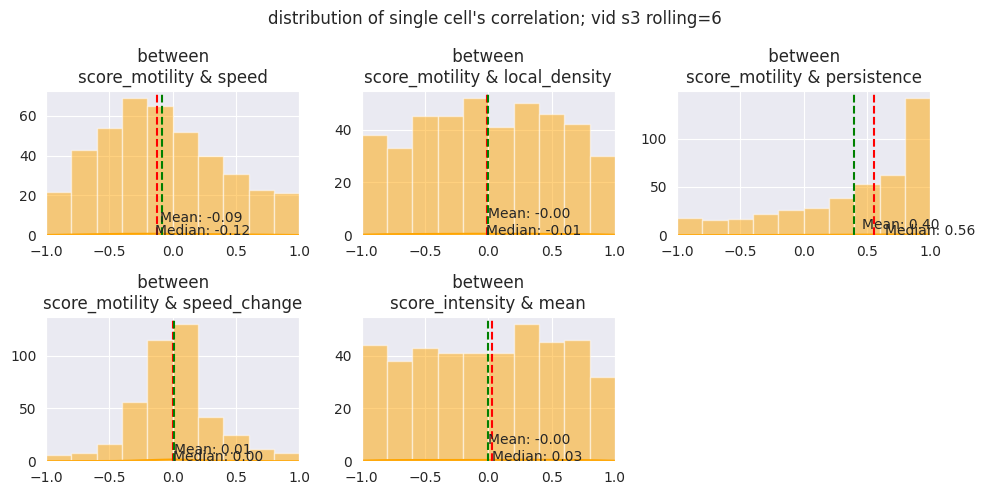

In [9]:
score_motility_features_list = [("score_motility", "speed"), ("score_motility", "local_density"), ("score_motility", "persistence"), ("score_motility", "speed_change"), ("score_intensity", "mean")] 
plot_single_cell_corr_dist(properties_df_s3, score_motility_features_list, "s3", rolling_w=6, time=(6,13))

#### correlations with time

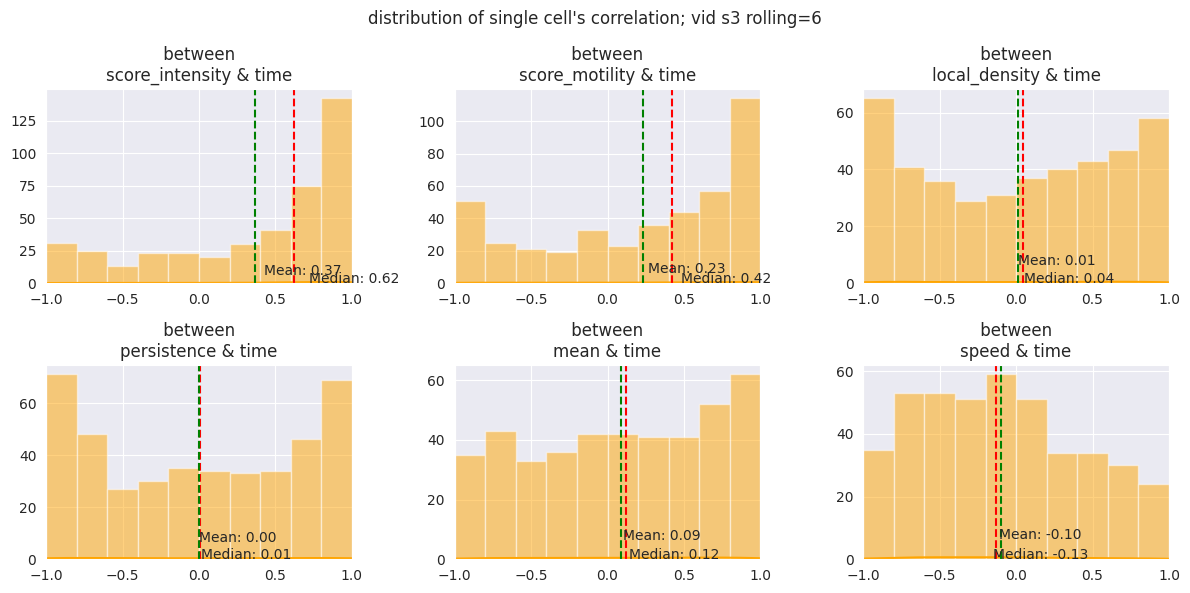

In [10]:
time_features_list = [("score_intensity", "time"),("score_motility", "time"), ("local_density", "time"), ("persistence", "time"),("mean", "time"), ("speed", "time") ] #("speed_change", "time")
plot_single_cell_corr_dist(properties_df_s3, time_features_list, "s3", rolling_w=6, time=(6,13), corr_metric="spearman")

### correlations of S2

the displayed data: 

S2 video, (DMSO, 211212_CD7_ERK_P38)- as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells from video S2.

#### correlations with cellular properties

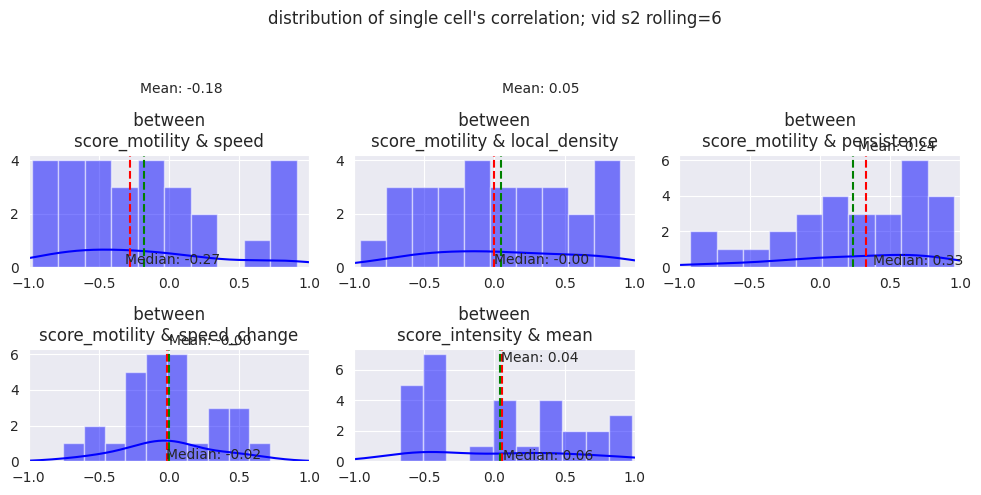

In [11]:
plot_single_cell_corr_dist(properties_df_s2, score_motility_features_list, "s2", rolling_w=6, time=(6,13), color="blue")

#### correlations with time

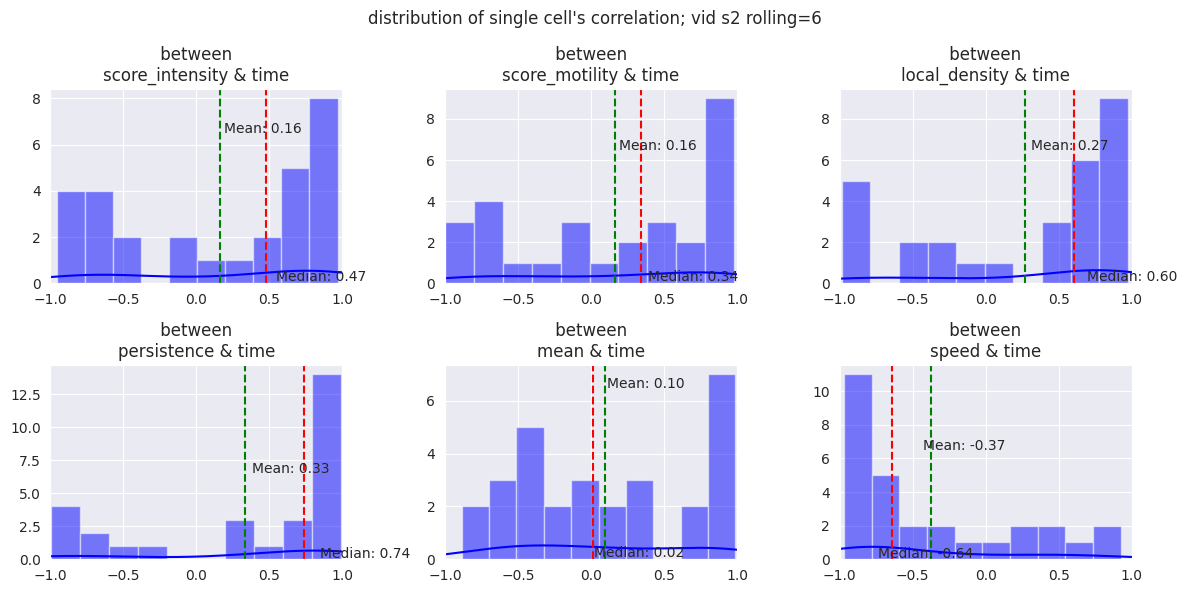

In [12]:
plot_single_cell_corr_dist(properties_df_s2, time_features_list, "s2", rolling_w=6, time=(6,13), color="blue")

### correlations of S6

the displayed data: 

S6 video, (DMSO, 211212_CD7_ERK_P38)- as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells from video S6.

#### correlations with cellular properties

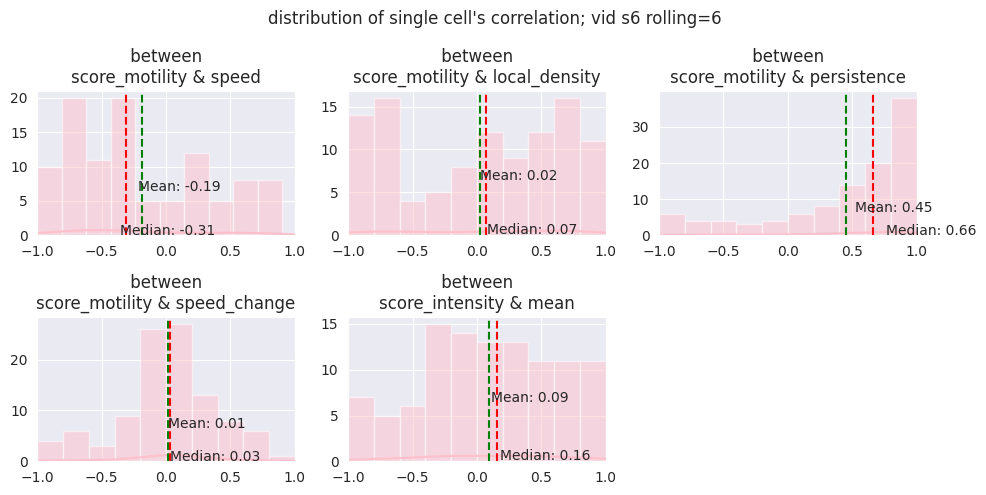

In [13]:
plot_single_cell_corr_dist(properties_df_s6, score_motility_features_list, "s6", rolling_w=6, time=(6,13), color="pink")

#### correlations with time

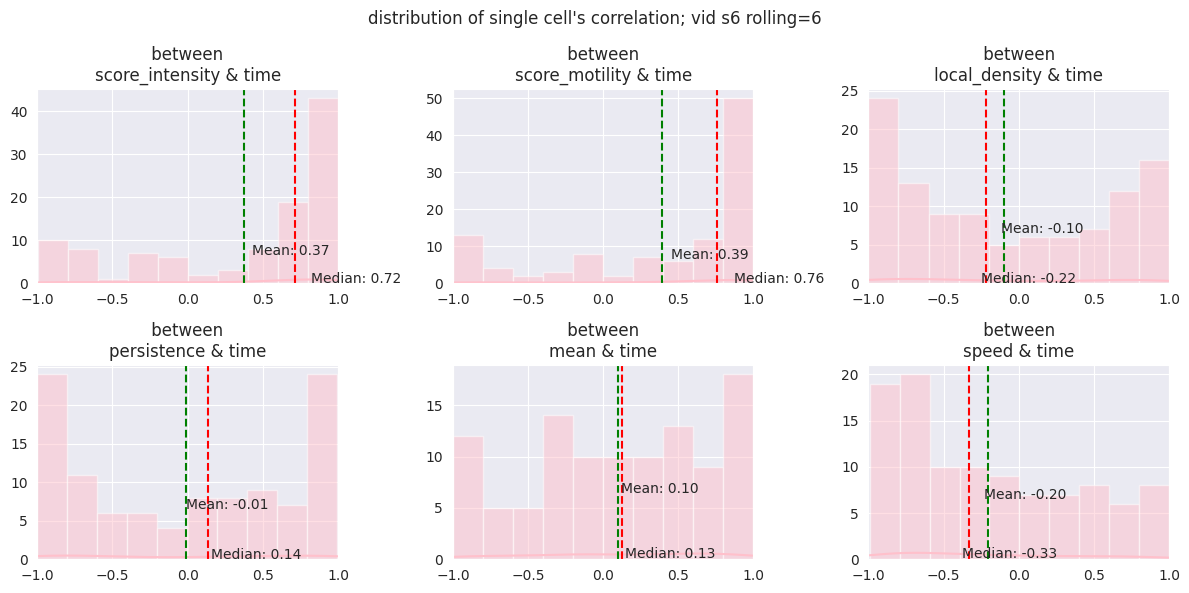

In [14]:
plot_single_cell_corr_dist(properties_df_s6, time_features_list, "s6", rolling_w=6, time=(6,13), color="pink")

### correlations of S8

the displayed data: 

S8 video, (DMSO, 211212_CD7_ERK_P38)- as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells from video S8.

#### correlations with cellular properties

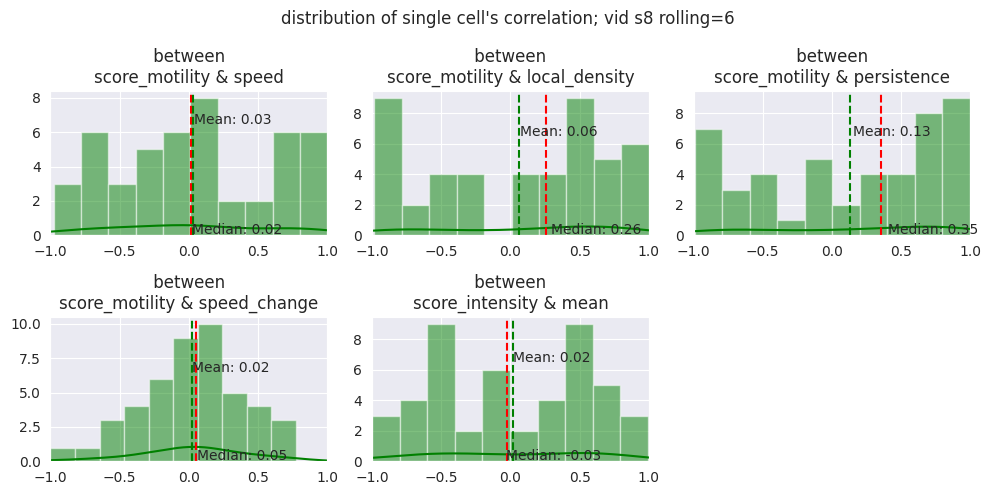

In [15]:
plot_single_cell_corr_dist(properties_df_s8, score_motility_features_list, "s8", rolling_w=6, time=(6,13), color="green")

#### correlations with time

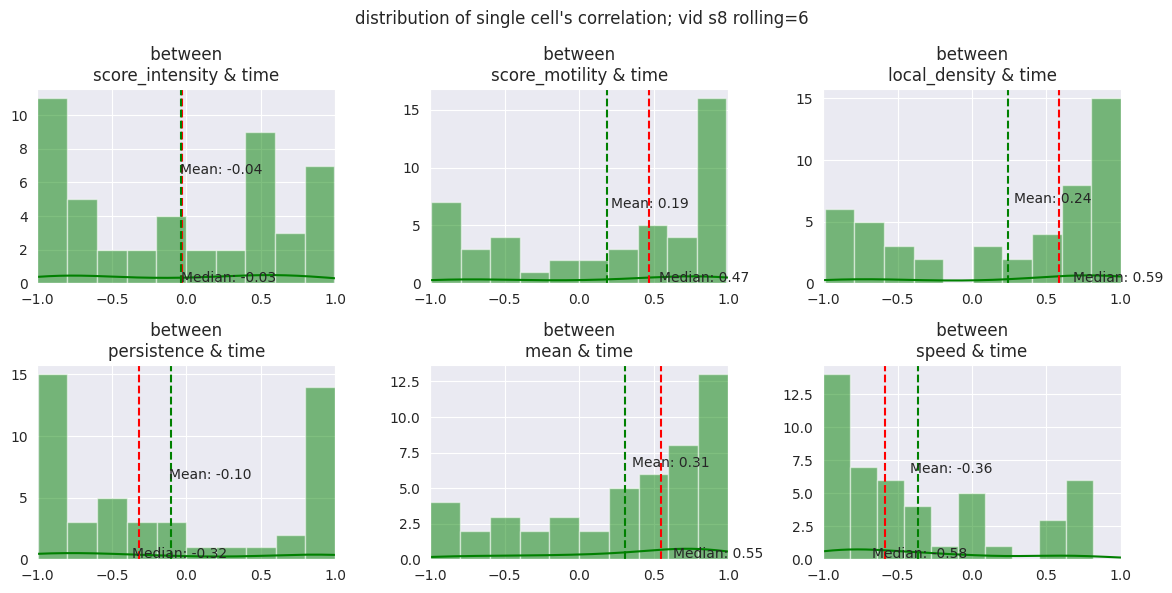

In [16]:
plot_single_cell_corr_dist(properties_df_s8, time_features_list, "s8", rolling_w=6, time=(6,13), color="green")

### correlations of S5

the displayed data: 

S5 video, (DMSO,211006_CD7_DMSO_ERKi)- as the test set data. the scores are based on a model that was trained on videos s2 (DMSO, 211212_CD7_ERK_P38) & s3 (DMSO, 211212_CD7_ERK_P38).
The followiing displayed trackes are *all* the manually-tracked cells from video S5.

#### correlations with cellular properties

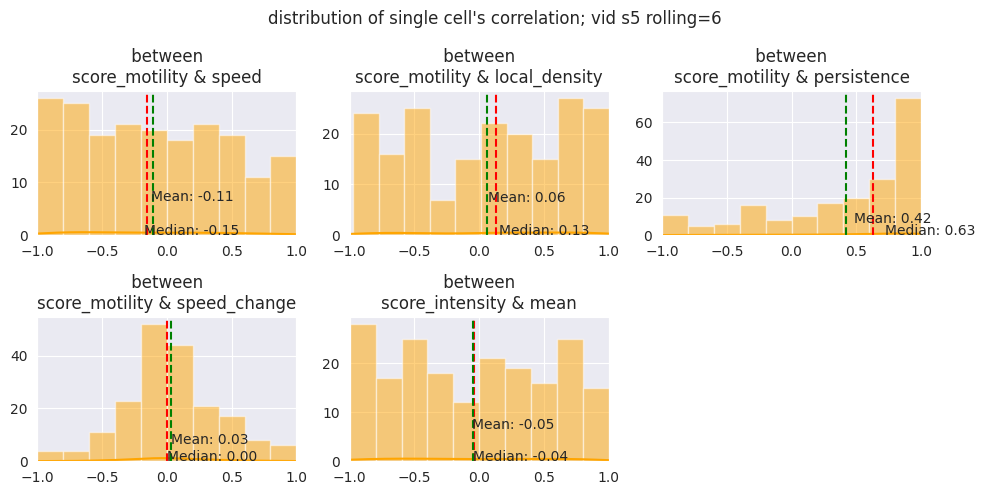

In [17]:
plot_single_cell_corr_dist(properties_df_s5, score_motility_features_list, "s5", rolling_w=6, time=(6,13), color="orange")

#### correlations with time

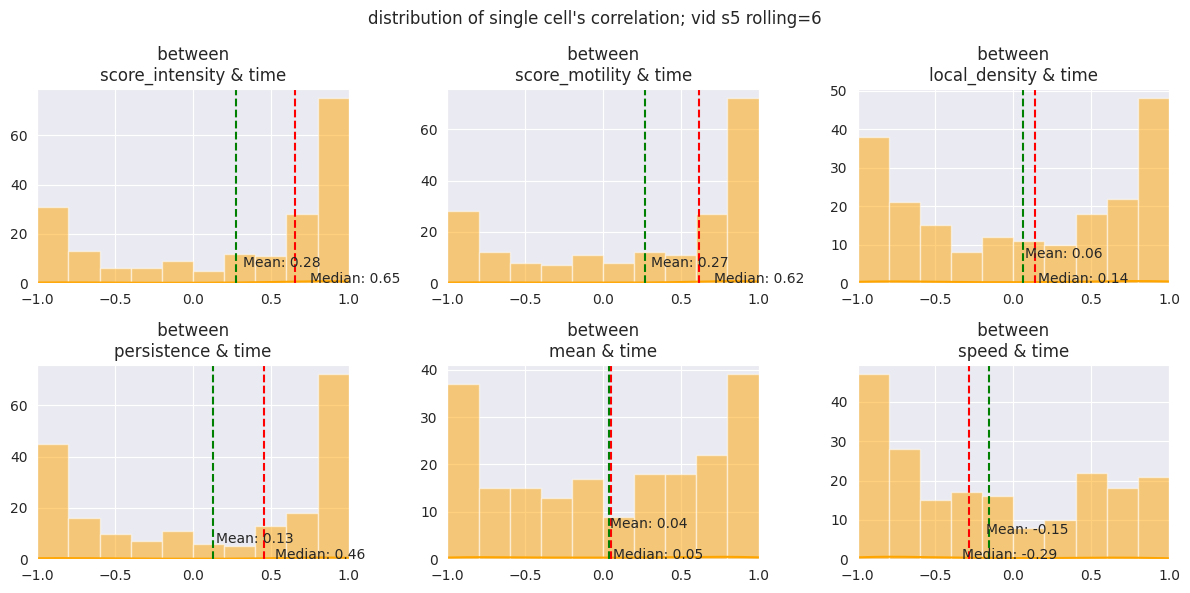

In [18]:
plot_single_cell_corr_dist(properties_df_s5, time_features_list, "s5", rolling_w=6, time=(6,13), color="orange")

### correlations of S1

the displayed data: 

S1 video, (DMSO,211006_CD7_DMSO_ERKi)- as the test set data. the scores are based on a model that was trained on videos s2 (DMSO, 211212_CD7_ERK_P38) & s3 (DMSO, 211212_CD7_ERK_P38).
The followiing displayed trackes are *all* the manually-tracked cells from video S1.

#### correlations with cellular properties

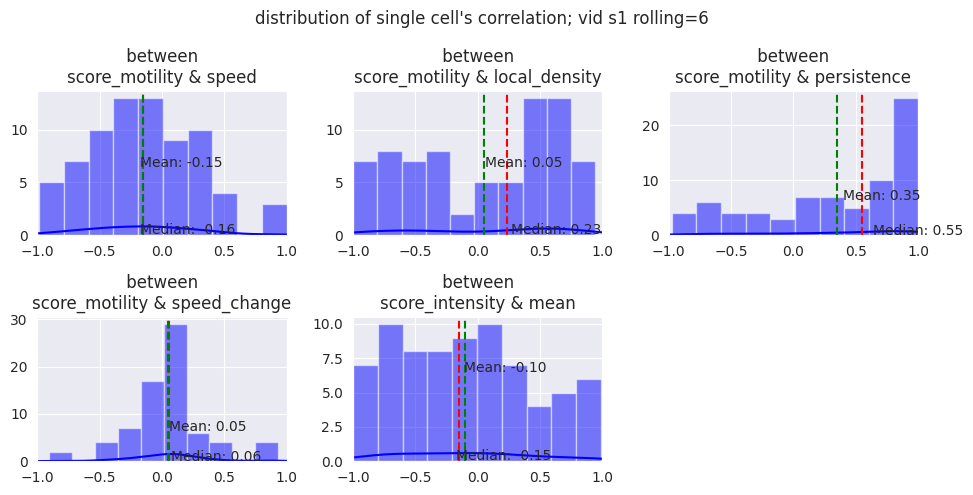

In [19]:
plot_single_cell_corr_dist(properties_df_s1, score_motility_features_list, "s1", rolling_w=6, time=(6,13), color="blue")

#### correlations with time

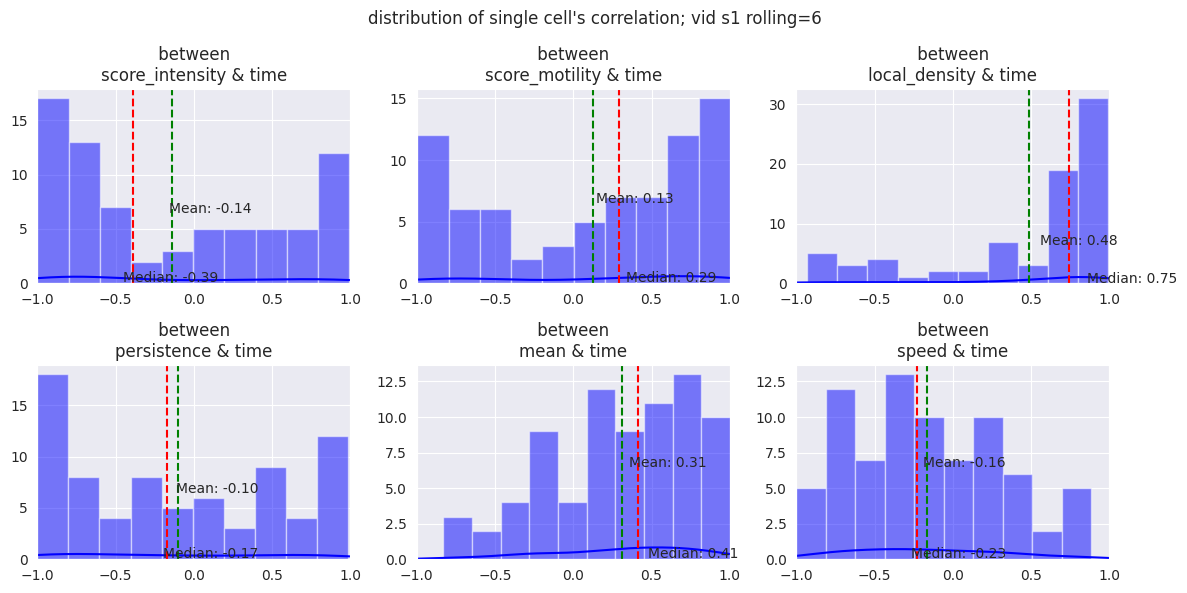

In [20]:
plot_single_cell_corr_dist(properties_df_s1, time_features_list, "s1", rolling_w=6, time=(6,13), color="blue")

## correlations of the models with time 

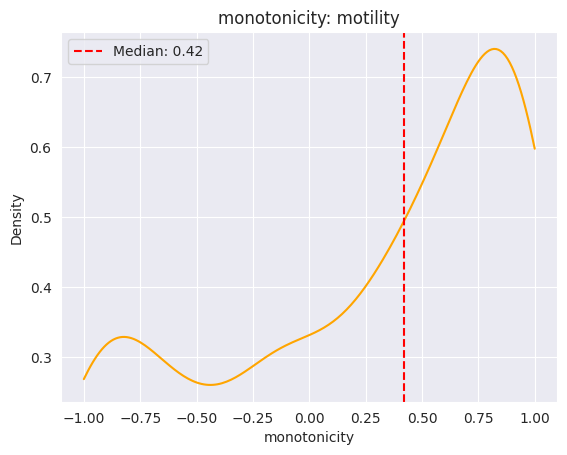

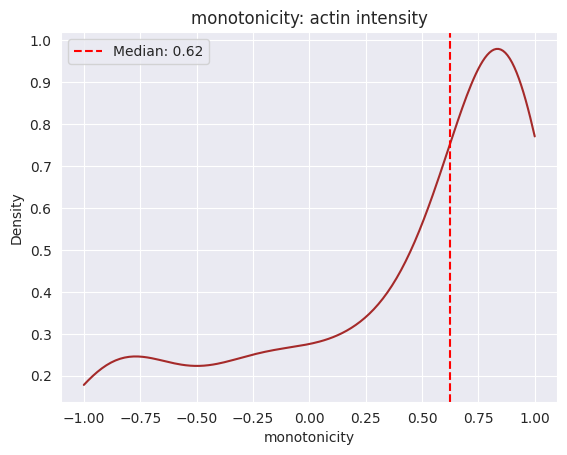

In [21]:
def plot_corr_distplot(corr, title, xlabel, color="gray"):
    median = np.nanmedian(corr)
    sns.kdeplot(corr, fill=False, color=color, cut=0)    
    plt.axvline(median, color='r', linestyle='dashed', label='Median: {:.2f}'.format(median))

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()
#     plt.clf()

corr_time_mot = get_corr_values(properties_df_s3 , (6,13), "score_motility", "time", rolling_w=6, corr_metric="spearman")
corr_time_int = get_corr_values(properties_df_s3, (6,13), "score_intensity", "time", rolling_w=6, corr_metric="spearman")

plot_corr_distplot(corr_time_mot, "monotonicity: motility", "monotonicity", color="orange")
plot_corr_distplot(corr_time_int, "monotonicity: actin intensity", "monotonicity", color="brown")

### predictors level of consent

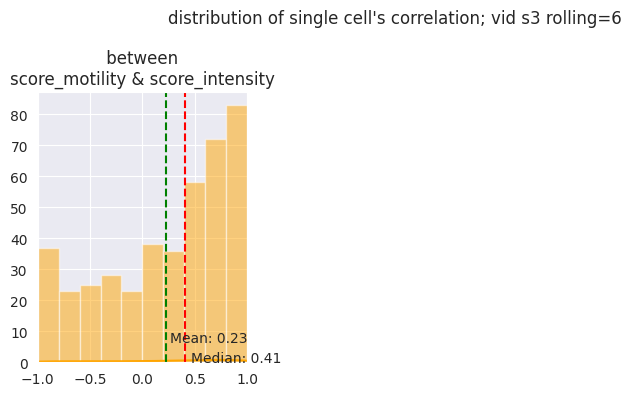

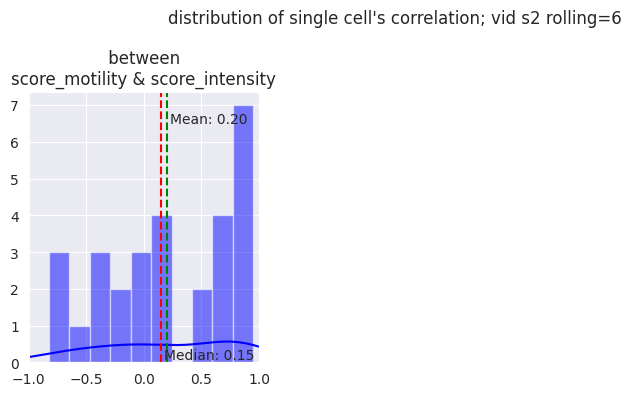

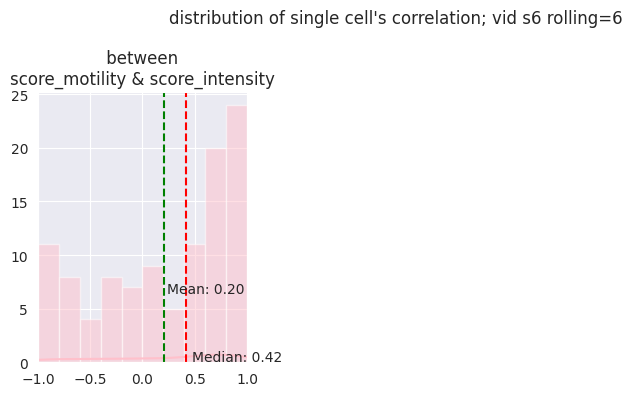

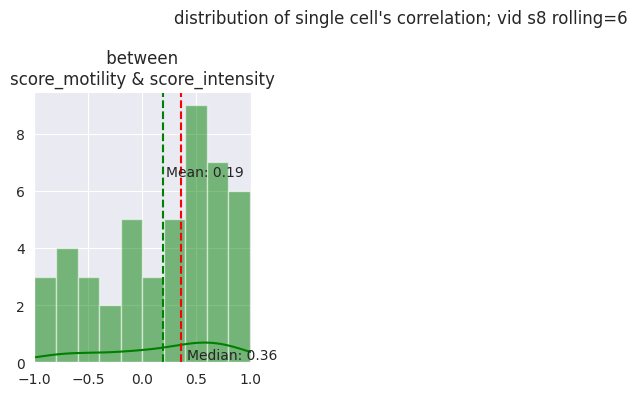

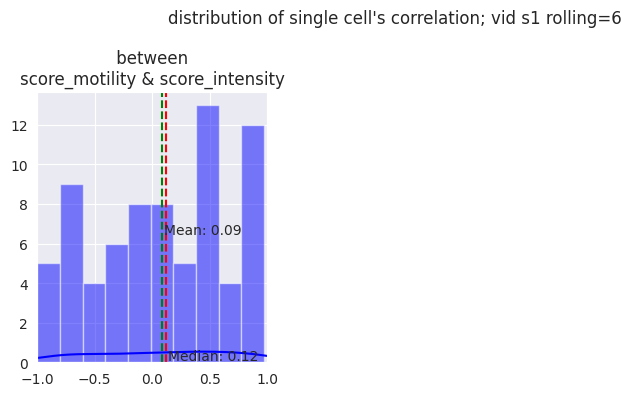

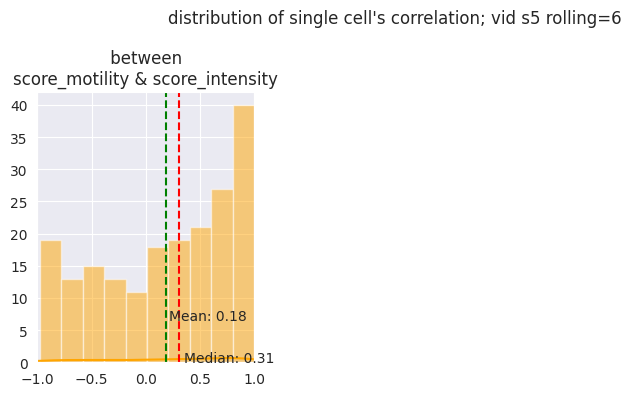

In [22]:
score_motility_features_list = [("score_motility", "score_intensity")] 

plot_single_cell_corr_dist(properties_df_s3, score_motility_features_list, "s3", rolling_w=6, time=(6,13), color="orange", corr_metric="pearson")
plot_single_cell_corr_dist(properties_df_s2, score_motility_features_list, "s2", rolling_w=6, time=(6,13), color="blue", corr_metric="pearson")
plot_single_cell_corr_dist(properties_df_s6, score_motility_features_list, "s6", rolling_w=6, time=(6,13), color="pink", corr_metric="pearson")
plot_single_cell_corr_dist(properties_df_s8, score_motility_features_list, "s8", rolling_w=6, time=(6,13), color="green", corr_metric="pearson")

plot_single_cell_corr_dist(properties_df_s1, score_motility_features_list, "s1", rolling_w=6, time=(6,13), color="blue", corr_metric="pearson")
plot_single_cell_corr_dist(properties_df_s5, score_motility_features_list, "s5", rolling_w=6, time=(6,13), color="orange", corr_metric="pearson")


In [3]:
properties_df_s3["Spot track ID"].nunique(), properties_df_s2["Spot track ID"].nunique()

(574, 81)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


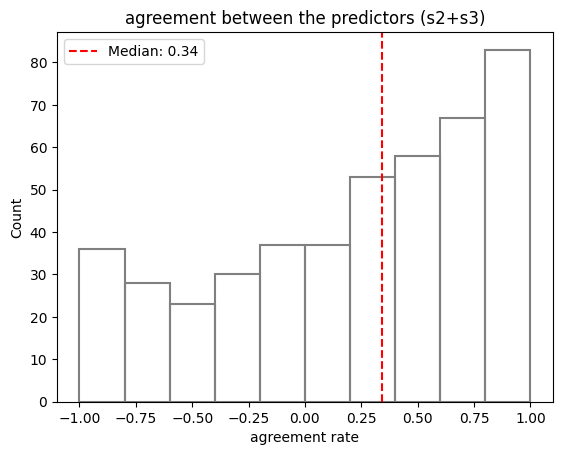

<Figure size 640x480 with 0 Axes>

In [7]:
def plot_corr_histplot(corr, title, xlabel, color="gray"):
    median = np.nanmedian(corr)
    sns.histplot(corr, fill=False, color=color)    
    plt.axvline(median, color='r', linestyle='dashed', label='Median: {:.2f}'.format(median))

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.savefig(consts.storage_path + f"eps_figs/agreement of both predictors (s2 + s3).eps", format="eps")
    plt.show()
    plt.clf()

corr = get_corr_values(pd.concat([properties_df_s3, properties_df_s2]), (6,13), "score_motility", "score_intensity", rolling_w=6, corr_metric="pearson")
plot_corr_histplot(corr, "agreement between the predictors (s2+s3)", "agreement rate", color="gray")

### use the differentiastion score & time correlation to clean noisy cells

In this section, I will use a correlation threshold to filter out cell trajectories with a low differentiation signal.

Objectives:
1. get a high signal cell trajectiries to explore correlations with cell properties on.
2. get the degree of consent between the models, regarding a cell trajectory's differentiation score.

In [24]:
CORR_THRESHOLD = 0.5

In [5]:
def get_cells_by_correlation_rate(data, corr_range, x_property, y_property, rolling_w=1, time=(0,25), corr_metric="spearman"):
    data = data.copy()
    data = data[(data["time"]>=time[0]) & (data["time"]<=time[1])]
    data[x_property] = data[x_property].rolling(rolling_w).mean()
    data[y_property] = data[y_property].rolling(rolling_w).mean()
    corr = data.astype('float64').groupby('Spot track ID')[[x_property, y_property]].corr(method=corr_metric).iloc[0::2][[y_property]]
    condition = (corr[y_property] >= corr_range[0]) & (corr[y_property] <= corr_range[1])

    cell_ids_above_thresh = corr[condition][y_property].reset_index()['Spot track ID']
    return data[data["Spot track ID"].isin(cell_ids_above_thresh)]

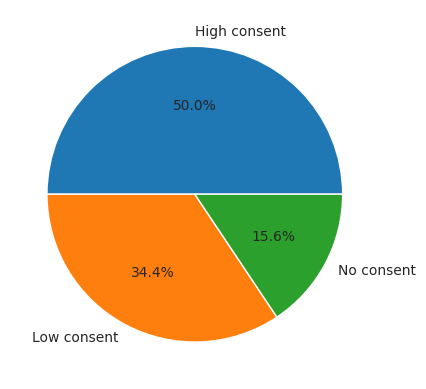

In [47]:
# see hoe many cells are above/below the median
high_consent_s3 = get_cells_by_correlation_rate(properties_df_s3, (0.4, 1), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
high_consent_s2 = get_cells_by_correlation_rate(properties_df_s2, (0.4, 1), "score_motility", "score_intensity", rolling_w=6, time=(6,13))

low_consent_s3 = get_cells_by_correlation_rate(properties_df_s3, (-0.4, 0.4), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
low_consent_s2 = get_cells_by_correlation_rate(properties_df_s2, (-0.4, 0.4), "score_motility", "score_intensity", rolling_w=6, time=(6,13))

no_consent_s3 = get_cells_by_correlation_rate(properties_df_s3, (-1, -0.4), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
no_consent_s2 = get_cells_by_correlation_rate(properties_df_s2, (-1, -0.4), "score_motility", "score_intensity", rolling_w=6, time=(6,13))

array = [high_consent_s3["Spot track ID"].nunique() + high_consent_s2["Spot track ID"].nunique(),
         low_consent_s3["Spot track ID"].nunique() + low_consent_s2["Spot track ID"].nunique(),
         no_consent_s3["Spot track ID"].nunique() + no_consent_s2["Spot track ID"].nunique()]
labels = ["High consent", "Low consent", "No consent"]
plt.pie(array, labels=labels, autopct='%1.1f%%')
plt.show()

num of ERKi cells:  180
num of DMSO cells:  16


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


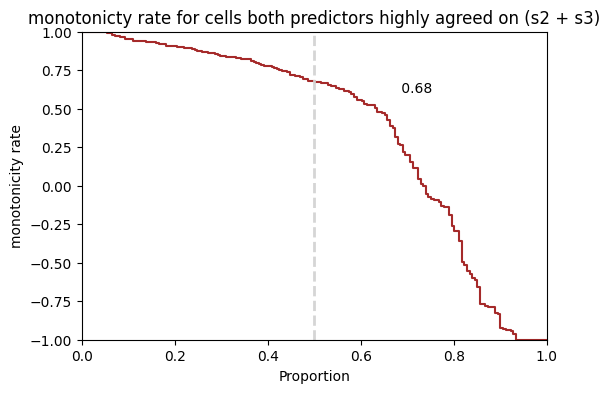

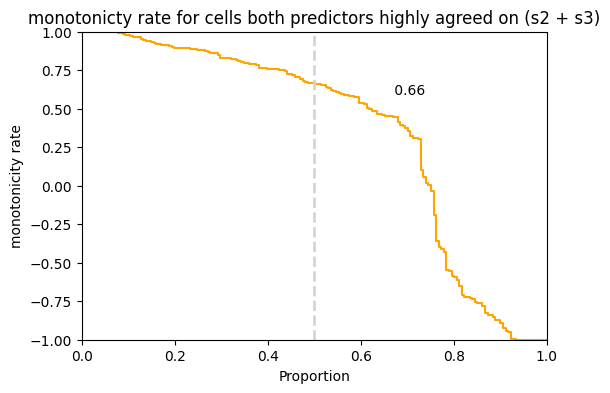

In [9]:
corr_range = (0.5, 1)

# high pos corr filtered tracks - models consent
high_consent_s3 = get_cells_by_correlation_rate(properties_df_s3, corr_range, "score_motility", "score_intensity", rolling_w=6, time=(6,13))
high_consent_s2 = get_cells_by_correlation_rate(properties_df_s2, corr_range, "score_motility", "score_intensity", rolling_w=6, time=(6,13))

print("num of ERKi cells: ", high_consent_s3["Spot track ID"].nunique())
print("num of DMSO cells: ", high_consent_s2["Spot track ID"].nunique())
corr_mot = get_corr_values(pd.concat([high_consent_s3, high_consent_s2]), (6,13), "score_motility", "time", rolling_w=6, corr_metric="spearman")
corr_int = get_corr_values(pd.concat([high_consent_s3, high_consent_s2]), (6,13), "score_intensity", "time", rolling_w=6, corr_metric="spearman")

# high_corr_df = pd.DataFrame({"avg score & time": (corr_mot + corr_int) / 2})
high_corr_df_mot = pd.DataFrame({"avg mot score & time": corr_mot})
high_corr_df_int = pd.DataFrame({"avg int score & time": corr_int})

def plot(data, y_val, color, label, modality):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.ecdfplot(data=data, y=y_val, color=color, complementary=True, label=label)
    med_val = data[y_val].quantile(.5)

    y_special = 0.5
    ax.text(med_val, med_val, f' {med_val:.2f}', ha='left', va='top')
    ax.axvline(0.5, linestyle='--', color='lightgray', lw=2, alpha=0.95)
    plt.ylim((-1,1))
    plt.ylabel("monotonicity rate")
    plt.title("monotonicty rate for cells both predictors highly agreed on (s2 + s3)")
    plt.savefig(consts.storage_path + f"eps_figs/monotonicty rate for cells both predictors (s2 + s3) {modality}.eps", format="eps")
#     plt.show()
    
plot(high_corr_df_int, "avg int score & time", color="brown", label="actin intensity predictor", modality="intensity")
plot(high_corr_df_mot, "avg mot score & time", color="orange", label="motility predictor", modality="motility")

In [ ]:
score_motility_features_list = [("score_motility", "speed"), ("score_motility", "local_density"), ("score_motility", "persistence"), ("score_motility", "speed_change"), ("score_intensity", "mean")] 
plot_single_cell_corr_dist(high_consent_s3, score_motility_features_list, "s3 filtered", rolling_w=6, time=(6,13))

In [ ]:
corr_range = (-1, -0.5)

# high neg corr filtered tracks - models consent
high_neg_consent_s3 = get_cells_by_correlation_rate(properties_df_s3, corr_range, "score_motility", "score_intensity", rolling_w=6, time=(6,13))
high_neg_consent_s2 = get_cells_by_correlation_rate(properties_df_s2, corr_range, "score_motility", "score_intensity", rolling_w=6, time=(6,13))

corr_mot = get_corr_values(pd.concat([high_neg_consent_s3, high_neg_consent_s2]), (6,13), "score_motility", "time", rolling_w=6, corr_metric="spearman")
corr_int = get_corr_values(pd.concat([high_neg_consent_s3, high_neg_consent_s2]), (6,13), "score_intensity", "time", rolling_w=6, corr_metric="spearman")

neg_corr_df = pd.DataFrame({"avg score & time": (corr_mot + corr_int) / 2})

fig, ax = plt.subplots(figsize=(6, 4))
sns.ecdfplot(data=neg_corr_df, y="avg score & time", ax=ax, color="gray", complementary=True) 

x_special = 0
for line in ax.get_lines():
    x, y = line.get_data()
    ind = np.argwhere(x <= x_special)[0, 0]  # first index where y is larger than x_special
    # y[ind] is the desired x-value
    ax.text(y[ind], x_special, f' {y[ind]:.1f}', ha='left', va='top')
ax.axhline(x_special, linestyle='--', color='lightgray', lw=2, alpha=0.95)
plt.ylim((-1,1))

plt.show()

score_motility_features_list = [("score_motility", "speed"), ("score_motility", "local_density"), ("score_motility", "persistence"), ("score_motility", "speed_change"), ("score_intensity", "mean")] 
plot_single_cell_corr_dist(high_neg_consent_s3, score_motility_features_list, "s3 filtered", rolling_w=6, time=(6,13))

In [ ]:
# plot single cells with no agreement on

def plot_single_cell_fusion_time(data, track_id, rolling_w=10):
    print(track_id, f"rolling w={rolling_w}")
    track_data = data[(data["Spot track ID"]==track_id)]
    track_data["score_intensity"] = track_data["score_intensity"].rolling(rolling_w).mean()
    track_data["score_motility"] = track_data["score_motility"].rolling(rolling_w).mean()

    if len(track_data)>1:
        sns.lineplot(x=track_data["time"], y="score_intensity", data=track_data, label="score actin_intensity", color="brown")

        sns.lineplot(x=track_data["time"], y="score_motility", data=track_data, label="score_motility", color="orange")

        plt.axvspan(6, 13, alpha=0.3, color='lightgray')
        plt.axvline(6, color='gray', linestyle='dashed')
        plt.axvline(13, color='gray', linestyle='dashed')
        plt.axhline(0.5, color='gray', linestyle='dashed')
        plt.ylabel("differentiation state")
        plt.title(f"cell ID={track_id}")
        plt.ylim((0,1))
        plt.show()

for id in high_neg_consent_s3["Spot track ID"].unique()[:10]:
    plot_single_cell_fusion_time(high_neg_consent_s3, id, rolling_w=10)

In [ ]:
corr_range = (-0.25, 0.25)

# high neg corr filtered tracks - models consent
high_consent_s3 = get_cells_by_correlation_rate(properties_df_s3, corr_range, "score_motility", "score_intensity", rolling_w=6, time=(6,13))
high_consent_s2 = get_cells_by_correlation_rate(properties_df_s2, corr_range, "score_motility", "score_intensity", rolling_w=6, time=(6,13))

corr_mot = get_corr_values(pd.concat([high_consent_s3, high_consent_s2]), (6,13), "score_motility", "time", rolling_w=6, corr_metric="spearman")
corr_int = get_corr_values(pd.concat([high_consent_s3, high_consent_s2]), (6,13), "score_intensity", "time", rolling_w=6, corr_metric="spearman")

low_corr_df = pd.DataFrame({"avg score & time": (corr_mot + corr_int) / 2})

fig, ax = plt.subplots(figsize=(6, 4))
sns.ecdfplot(data=low_corr_df, y="avg score & time", ax=ax, color="gray", complementary=True) 

x_special = 0
for line in ax.get_lines():
    x, y = line.get_data()
    ind = np.argwhere(x <= x_special)[0, 0]  # first index where y is larger than x_special
    # y[ind] is the desired x-value
    ax.text(y[ind], x_special, f' {y[ind]:.1f}', ha='left', va='top')
ax.axhline(x_special, linestyle='--', color='lightgray', lw=2, alpha=0.95)
plt.ylim((-1,1))

plt.show()

score_motility_features_list = [("score_motility", "speed"), ("score_motility", "local_density"), ("score_motility", "persistence"), ("score_motility", "speed_change"), ("score_intensity", "mean")] 
plot_single_cell_corr_dist(high_consent_s3, score_motility_features_list, "s3 filtered", rolling_w=6, time=(6,13))

In [ ]:
high_corr_df["level of agreement"] = "high agreement"
low_corr_df["level of agreement"] = "low agreement"
neg_corr_df["level of agreement"] = "no agreement"

all_corrs = pd.concat([high_corr_df, low_corr_df, neg_corr_df], ignore_index=True)
sns.ecdfplot(data=all_corrs, y="avg score & time", color="gray", complementary=True, hue="val") 
plt.ylabel("monotonicity rate")

plt.show()
plt.clf()

In [ ]:
corr_range = (0.5, 1)

# high pos corr filtered tracks
high_corr_mot = get_cells_by_correlation_rate(properties_df_s3, corr_range, "score_motility", "time", rolling_w=6, time=(6,13))
high_corr_act_int = get_cells_by_correlation_rate(properties_df_s3, corr_range, "score_intensity", "time", rolling_w=6, time=(6,13))
high_corr_mot_int_dif = high_corr_mot[high_corr_mot["Spot track ID"].isin(high_corr_act_int["Spot track ID"].unique())]

high_corr_mots_2 = get_cells_by_correlation_rate(properties_df_s2, corr_range, "score_motility", "time", rolling_w=6, time=(6,13))
high_corr_act_int_s2 = get_cells_by_correlation_rate(properties_df_s2, corr_range, "score_intensity", "time", rolling_w=6, time=(6,13))
high_corr_mot_int_con = high_corr_mots_2[high_corr_mots_2["Spot track ID"].isin(high_corr_act_int_s2["Spot track ID"].unique())]

In [ ]:
corr_range = (-0.25, 0.25)

# low corr filtered tracks
low_corr_mot = get_cells_by_correlation_rate(properties_df_s3, corr_range, "score_motility", "time", rolling_w=6, time=(6,13))
low_corr_act_int = get_cells_by_correlation_rate(properties_df_s3, corr_range, "score_intensity", "time", rolling_w=6, time=(6,13))
low_corr_mot_int_dif = low_corr_mot[low_corr_mot["Spot track ID"].isin(low_corr_act_int["Spot track ID"].unique())]

low_corr_mots_2 = get_cells_by_correlation_rate(properties_df_s2, corr_range, "score_motility", "time", rolling_w=6, time=(6,13))
low_corr_act_int_s2 = get_cells_by_correlation_rate(properties_df_s2, corr_range, "score_intensity", "time", rolling_w=6, time=(6,13))
low_corr_mot_int_con = low_corr_mots_2[low_corr_mots_2["Spot track ID"].isin(low_corr_act_int_s2["Spot track ID"].unique())]

In [ ]:
corr_range = (-1, -0.5)

# negative corr filtered tracks
neg_corr_mot = get_cells_by_correlation_rate(properties_df_s3, corr_range, "score_motility", "time", rolling_w=6, time=(6,13))
neg_corr_act_int = get_cells_by_correlation_rate(properties_df_s3, corr_range, "score_intensity", "time", rolling_w=6, time=(6,13))
neg_corr_mot_int_dif = neg_corr_mot[neg_corr_mot["Spot track ID"].isin(neg_corr_act_int["Spot track ID"].unique())]

neg_corr_mots_2 = get_cells_by_correlation_rate(properties_df_s2, corr_range, "score_motility", "time", rolling_w=6, time=(6,13))
neg_corr_act_int_s2 = get_cells_by_correlation_rate(properties_df_s2, corr_range, "score_intensity", "time", rolling_w=6, time=(6,13))
neg_corr_mot_int_con = neg_corr_mots_2[neg_corr_mots_2["Spot track ID"].isin(neg_corr_act_int_s2["Spot track ID"].unique())]

In [ ]:
corr = get_corr_values(pd.concat([high_corr_mot_int_con, high_corr_mot_int_dif]), (6,13), "score_motility", "score_intensity", rolling_w=6, corr_metric="pearson")
plot_corr_distplot(corr,"(s2 + s3)\n(high correlation with time)")

In [ ]:
corr = get_corr_values(pd.concat([low_corr_mot_int_con, low_corr_mot_int_dif]), (6,13), "score_motility", "score_intensity", rolling_w=6, corr_metric="pearson")
plot_corr_distplot(corr,"(s2 + s3)\n(high correlation with time)")

In [ ]:
score_motility_features_list = [("score_motility", "speed"), ("score_motility", "local_density"), ("score_motility", "persistence"), ("score_motility", "speed_change"), ("score_intensity", "mean")] 
plot_single_cell_corr_dist(high_corr_mot_int_dif, score_motility_features_list, "s3 filtered", rolling_w=6, time=(6,13))

In [ ]:
plot_single_cell_corr_dist(high_corr_mot_int_dif, time_features_list, "s3", rolling_w=6, time=(6,13))

# correlations- global

In [ ]:
time = (6,13)
comp_features_list = [("score_motility", "speed"), ("score_motility", "local_density"), ("score_motility", "speed_change"), ("score_motility", "persistence"), ("score_intensity", "mean")]
corr_s3 = pd.DataFrame()
corr_s6 = pd.DataFrame()
for x_property, y_property in comp_features_list:
    corr_s3[f"{x_property} over {y_property}"] = get_corr_values(properties_df_s3[["Spot frame", "time", "Spot track ID", x_property, y_property ]], time, x_property, y_property, rolling_w=6)
    
    corr_s6[f"{x_property} over {y_property}"] = get_corr_values(properties_df_s6[["Spot frame", "time", "Spot track ID", x_property, y_property ]], time, x_property, y_property, rolling_w=6)

corr_s3["name"]= "S3 (ERK)"
corr_s6["name"] = "S6 (ERK + P38)"

df = pd.concat([corr_s3, corr_s6])
df_long = df.melt(id_vars=['name'])

In [ ]:
sns.boxplot(data=df_long, orient="h", x="value", y="variable", hue="name", palette={"S3 (ERK)": "orange", "S6 (ERK + P38)": "pink"})
plt.axvline(0, color='gray', linestyle='dashed')
plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.0))
plt.show()